In [2]:
from google.colab import drive
drive.mount('/content/drive')
# !pip install --upgrade --force-reinstall `cat /content/gdrive/My\ Drive/colab_installed.txt`

#Подключение Google Drive, заккоментированная строка устанавливает (или обновляет) использованные библиотеки из файла .txt)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# !pip freeze --local > /content/drive/MyDrive/colab_installed.txt # Записать все используемые библиотеки в текстовый файл

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Flatten, Activation, Dropout
from keras import applications, optimizers
import os
import pandas as pd
import os.path
import random as rd
import matplotlib.pyplot as plt


In [ ]:
import wget

In [2]:
main_path = './drive/MyDrive/ColabNotebooks/' # В данном месте нужно вписать абсолютный путь к проекту, я использовал Google Colab

In [3]:
class Make_data: #Класс, который скачивает файлы по ссылкам из csv файла, удаляет повреждённые файлы, создаёт папки для Train, Validation и Test и разделяет данные по этим папкам

  def __init__(self, main_path, folders, train_folder, testval_folder, classes, class_csv):
    self.main_path = main_path
    self.train_folder = train_folder
    self.testval_folder = testval_folder
    self.classes = classes 
    self.folders = folders
    self.csv = class_csv
                
  def download_data(self):
    for i in range(2):
      data_class = pd.read_csv(self.main_path + self.csv[i],encoding='ascii', header=None)
      for j in range(len(data_class)):
        wget.download(data_class[0][j], self.main_path + self.train_folder + self.classes[i] + '/')

  def make_dir(self):
      for folders in self.folders:
        for classe in self.classes:
          if folders == 'Test/':
            os.makedirs(self.main_path + folders + classe + '/' + classe)
          else: 
            os.makedirs(self.main_path + folders + classe)

  def divide_data(self):
      for folder in self.testval_folder:
        for classe in self.classes:
          # print(folder + '111')
          class_path = []
          class_name = []
          basepath = self.main_path + self.train_folder + classe
          # print(basepath)
          with os.scandir(basepath) as entries:
            for entry in entries:
                if entry.is_file():
                    class_path.append(entry.path)
                    class_name.append(entry.name)
          rd.seed(1)
          random_index = rd.sample(range(len(class_path)), int(len(class_path)*0.1))
          for i in random_index:
            if folder == 'Test/':
              os.rename(class_path[i], self.main_path + folder + classe + '/' + classe + '/' + class_name[i])
            else:  
              os.rename(class_path[i], self.main_path + folder + classe + '/' + class_name[i])
 
  def filter_data (self):
      num_skipped = 0
      for folder_name in self.classes:
          folder_path = self.main_path + self.train_folder + folder_name
          for fname in os.listdir(folder_path):
              fpath = os.path.join(folder_path, fname)
              if os.path.isfile(fpath):
                  try:
                      fobj = open(fpath, "rb")
                      is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
                  finally:
                      fobj.close()

                  if not is_jfif:
                      num_skipped += 1
                      os.remove(fpath)

      print("Deleted %d images" % num_skipped)

    

In [5]:
md = Make_data(main_path, ['Train/','Val/', 'Test/'], 'Train/', ['Val/', 'Test/'], ['Georges', 'Non_Georges'], ['georges.csv', 'non_georges.csv'])
# md.make_dir()
# md.download_data()
# md.filter_data()
md.divide_data()
del md
#Создаём класс, входные переменные оставляем такие же, после махинаций, класс удаляется

In [6]:
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    main_path + "Train",
    labels="inferred",
    class_names = ["Georges", "Non_Georges"],
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    main_path + "Val",
    labels="inferred",
    class_names = ["Georges", "Non_Georges"],
    validation_split=0.4,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

#Создаём два объекта которые содержат в себе данные для обучения и валидации

Found 2325 files belonging to 2 classes.
Using 1860 files for training.
Found 286 files belonging to 2 classes.
Using 114 files for validation.


In [7]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical", seed = 1337),
        layers.experimental.preprocessing.RandomRotation(0.1, seed = 1337),
        layers.experimental.preprocessing.Normalization(axis=-1)
    ]
)
#Расширим датасет с помощью аугментации данных

In [8]:
augmented_train_ds = train_ds.map(
  lambda x, y: (data_augmentation(x, training=True), y))

In [9]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.shuffle(1000, 1337).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
#Используем предварительную выборку, где количество потребляем пакетов за один шаг обучения настраивается динамически

In [10]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    activation = "sigmoid"
    units = 1

    tf.random.set_seed(1337)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)

#Строим модель

In [11]:
epochs = 20

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
history = model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds)
model.save(main_path + 'Model')

Epoch 1/20
59/59 [==============================] - 699s 7s/step - loss: 0.7509 - accuracy: 0.5786 - val_loss: 0.6642 - val_accuracy: 0.6404
Epoch 2/20
59/59 [==============================] - 427s 7s/step - loss: 0.6632 - accuracy: 0.6633 - val_loss: 0.6518 - val_accuracy: 0.6404
Epoch 3/20
59/59 [==============================] - 423s 7s/step - loss: 0.6326 - accuracy: 0.6769 - val_loss: 0.6684 - val_accuracy: 0.6404
Epoch 4/20
59/59 [==============================] - 425s 7s/step - loss: 0.6268 - accuracy: 0.6833 - val_loss: 0.6837 - val_accuracy: 0.6404
Epoch 5/20
59/59 [==============================] - 426s 7s/step - loss: 0.6017 - accuracy: 0.6939 - val_loss: 0.7202 - val_accuracy: 0.6404
Epoch 6/20
59/59 [==============================] - 429s 7s/step - loss: 0.6136 - accuracy: 0.6925 - val_loss: 0.7157 - val_accuracy: 0.6404
Epoch 7/20
59/59 [==============================] - 430s 7s/step - loss: 0.5712 - accuracy: 0.7174 - val_loss: 0.6823 - val_accuracy: 0.6404
Epoch 8/20
59

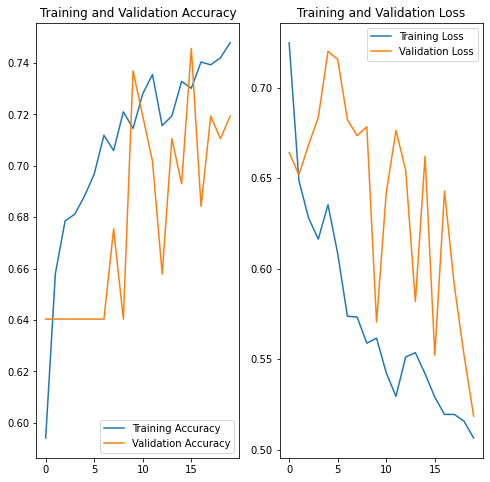

In [12]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# new_model = tf.keras.models.load_model(main_path + 'Model') #Загрузить сохранённую модель# loss, acc = new_model.evaluate(testGN, verbose=2)

In [22]:
testT = tf.keras.preprocessing.image_dataset_from_directory(
    main_path + "Test/Georges/",
    labels="inferred",
    class_names = ["Georges"],
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

# Создаём объект, содержащий только Георгиев

Found 113 files belonging to 1 classes.


In [23]:
predT = model.predict(testT)


In [38]:
# predT

In [62]:
path, dirs, files = next(os.walk(main_path + 'Test/Georges/Georges'))
file_count = len(files)
sum=0
for pred in predT:
  if pred[0] < 0.6:
    sum+=1
print(sum/file_count)

#Проверим точность обученной модели на тестовых данных, где мы определяем Георгий ли на картинке

0.4424778761061947


In [25]:
testN = tf.keras.preprocessing.image_dataset_from_directory(
    main_path + "Test/Non_Georges/",
    labels="inferred",
    class_names = ["Non_Georges"],
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

# Создаём объект, содержащий только Не Георгиев

Found 145 files belonging to 1 classes.


In [26]:
predN = model.predict(testN)


In [39]:
# predN

In [63]:
path, dirs, files = next(os.walk(main_path + 'Test/Non_Georges/Non_Georges'))
file_count = len(files)
sum=0
for pred in predN:
  if pred[0] > 0.6:
    sum+=1
print(sum/file_count)

#Проверим точность обученной модели на тестовых данных, где мы определяем Не Георгий ли на картинке

0.9172413793103448


In [55]:
testGN = tf.keras.preprocessing.image_dataset_from_directory(
    main_path + "Test/",
    labels="inferred",
    class_names = ["Georges", "Non_Georges"],
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

# Создаём объект, содержащий Георгиев и Не Георгиев

Found 258 files belonging to 2 classes.


In [59]:
def define(img):

    # img = keras.preprocessing.image.load_img(path, target_size=image_size)
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis

    predictions = model.predict(img_array)
    score = predictions[0]
    if score < 0.6:
      return "George"
    else:
      return "Non_George"

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in testGN.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(define(images[i]))
        plt.axis("off")


#Запустить ячейку, чтобы посмотреть предсказания модели на тестовых данных